In [1]:
from IPython.display import clear_output
clear_output()

In [2]:
import os
import keras
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
import tensorflow.image as tfi
import cv2
from PIL import Image

# Data
from tensorflow.keras.preprocessing.image import img_to_array,load_img

# Data Viz
import matplotlib.pyplot as plt

# Model 
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Layer
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import Dropout, Lambda
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Input,Activation
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization

# Callbacks 
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# Metrics
from keras.metrics import MeanIoU

Load Image

In [3]:
def load_image(image, SIZE):
    return np.round(tfi.resize(img_to_array(load_img(image))/255.,(SIZE, SIZE)),4)
def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:image_paths = image_paths[:trim]
    
    if mask:images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))
    
    for i,image in enumerate(image_paths):
        img = load_image(image,SIZE)
        if mask:images[i] = img[:,:,:1]
        else:images[i] = img
    
    return images

Show Image

In [4]:
def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4,threshold=0.8):
    mask = tf.where(mask >= threshold, 0, 1)  # 二值化處理
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

In [5]:
SIZE = 256
train_path = 'D:/test/img/train/'
classes = sorted(os.listdir(train_path))
train_path_mask = sorted([sorted(glob(train_path + "/*mask.jpg"))])

train_image_paths = []
train_mask_paths = []
for input_path in train_path_mask:
    for path in input_path:
        img_path = path.replace('_mask','')
        train_image_paths.append(img_path)
        train_mask_paths.append(path)
train_images = load_images(train_image_paths, SIZE)
train_masks = load_images(train_mask_paths, SIZE, mask=True)

In [6]:
SIZE = 256
val_path = 'D:/test/img/val/'
classes = sorted(os.listdir(val_path))
val_path_mask = sorted([sorted(glob(val_path + "/*mask.jpg"))])

val_image_paths = []
val_mask_paths = []
for input_path in val_path_mask:
    for path in input_path:
        img_path = path.replace('_mask','')
        val_image_paths.append(img_path)
        val_mask_paths.append(path)
val_images = load_images(val_image_paths, SIZE)
val_masks = load_images(val_mask_paths, SIZE, mask=True)

UNet

In [35]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

model = unet()
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy', MeanIoU(num_classes=2, name='IoU')],run_eagerly=True)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_50 (Conv2D)             (None, 256, 256, 64  1792        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 activation_36 (Activation)     (None, 256, 256, 64  0           ['conv2d_50[0][0]']              
                                )                                                           

Training

In [36]:
# Config Training
BATCH_SIZE = 20
SPE = len(train_images)//BATCH_SIZE

results = model.fit(
    train_images, train_masks,
    validation_data=(val_images, val_masks),
    epochs=30,
    steps_per_epoch=SPE,
    batch_size=BATCH_SIZE,
)
model.save('Unet1.h5')

Epoch 1/30
31/31 [==============================] - 1592s 51s/step - loss: 0.2663 - accuracy: 0.6479 - IoU: 0.4816 - val_loss: 40.3276 - val_accuracy: 0.0419 - val_IoU: 0.1143
Epoch 2/30
31/31 [==============================] - 1497s 49s/step - loss: 0.1064 - accuracy: 0.6722 - IoU: 0.4813 - val_loss: 3.7409 - val_accuracy: 0.3029 - val_IoU: 0.4787
Epoch 3/30
31/31 [==============================] - 1547s 50s/step - loss: 0.0883 - accuracy: 0.6735 - IoU: 0.4814 - val_loss: 0.2804 - val_accuracy: 0.6518 - val_IoU: 0.4830
Epoch 4/30
31/31 [==============================] - 1563s 50s/step - loss: 0.0813 - accuracy: 0.6729 - IoU: 0.4815 - val_loss: 0.2512 - val_accuracy: 0.6533 - val_IoU: 0.4830
Epoch 5/30
31/31 [==============================] - 1550s 50s/step - loss: 0.0760 - accuracy: 0.6726 - IoU: 0.4812 - val_loss: 0.3858 - val_accuracy: 0.6353 - val_IoU: 0.4830
Epoch 6/30
31/31 [==============================] - 1548s 50s/step - loss: 0.0725 - accuracy: 0.6746 - IoU: 0.4816 - val_los

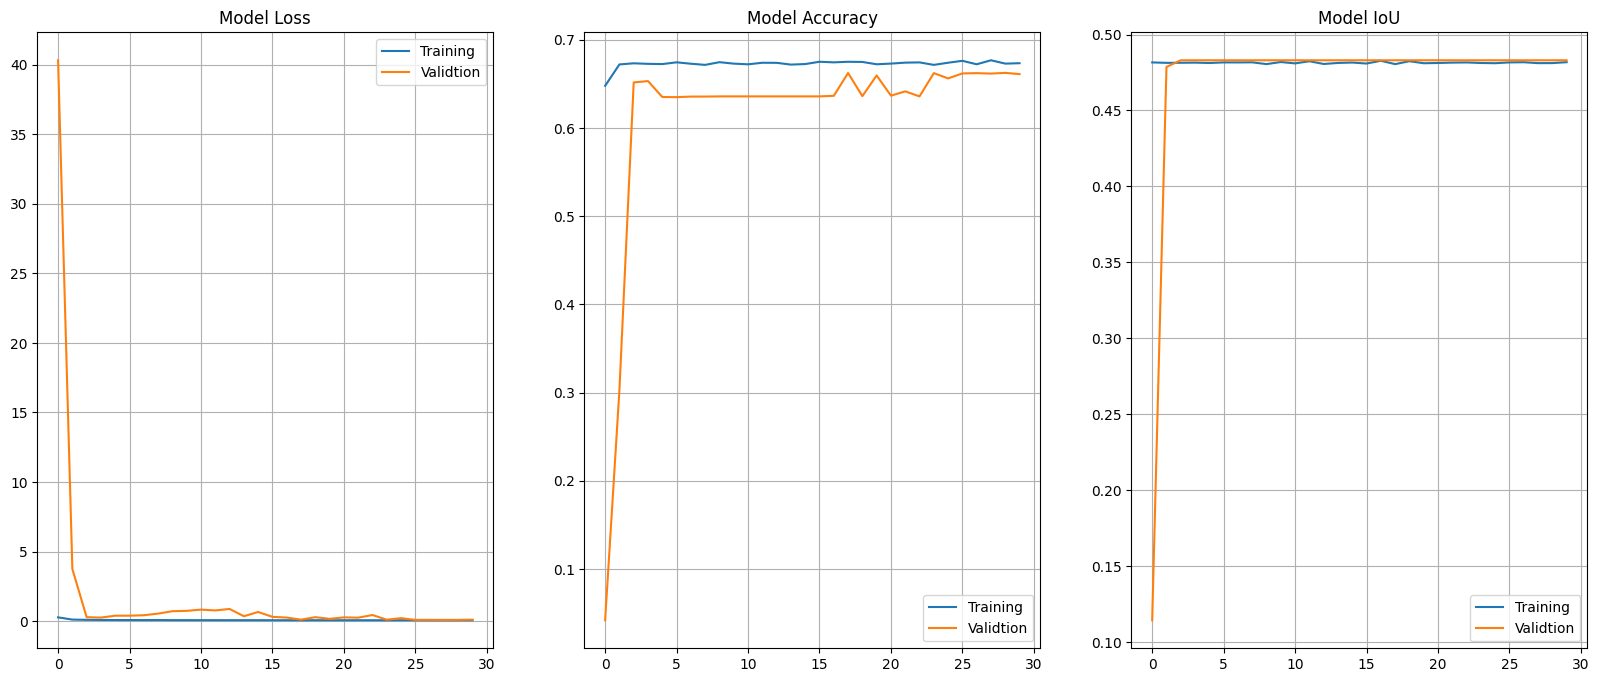

In [37]:
loss, accuracy, iou, val_loss, val_accuracy,val_iou = results.history.values()
plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.title("Model Loss")
plt.plot(loss, label="Training")
plt.plot(val_loss, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.title("Model Accuracy")
plt.plot(accuracy, label="Training")
plt.plot(val_accuracy, label="Validtion")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.title("Model IoU")
plt.plot(iou, label="Training")
plt.plot(val_iou, label="Validtion")
plt.legend()
plt.grid()

plt.show()

In [7]:
test_model = load_model('Unet1.h5')
test_path = 'D:/test/img/test'
test_file = sorted(sorted(glob(test_path + "/*.jpg")))
# test_mask_path = 'D:/test/jpg/img_jpg/test/test_mask'
# test_mask = sorted(sorted(glob(test_mask_path + "/*mask.jpg")))

1/1 [==============================] - 1s 972ms/step


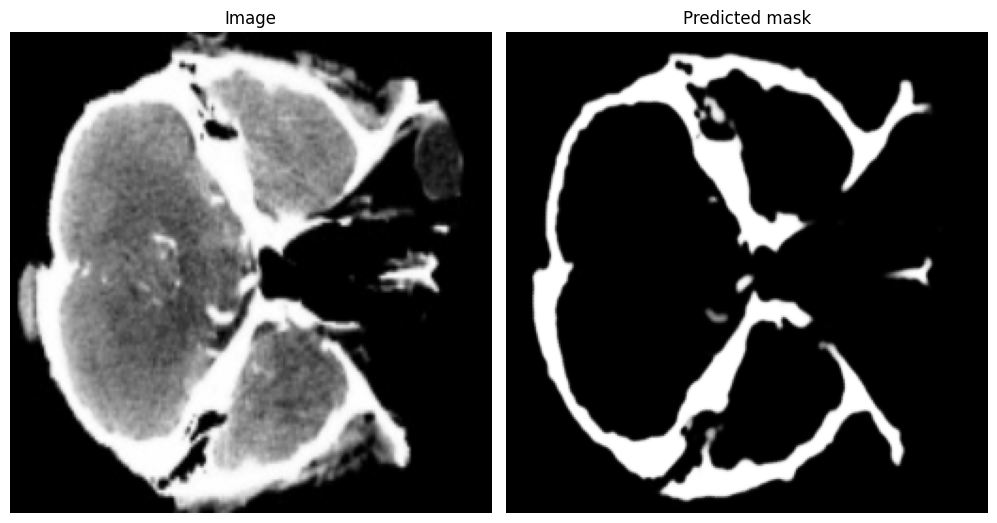

In [8]:
images = load_images(test_file, SIZE)
# mask = load_images(test_mask, SIZE)
plt.figure(figsize=(20,25))
for i, image in enumerate(images):
    # 預測掩膜
    pred_mask = test_model.predict(image[np.newaxis, ...])
    # 歸一化掩膜
    pred_mask /= np.max(pred_mask)
    # 顯示圖像、預測掩膜、真實掩膜以及 IOU 值
    plt.subplot(len(images), 4, i*4+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Image")

    plt.subplot(len(images), 4, i*4+2)
    plt.imshow(pred_mask[0], cmap='gray')
    plt.axis('off')
    plt.title(f"Predicted mask")

    # plt.subplot(len(images), 4, i*4+3)
    # plt.imshow(mask[0], cmap='gray')
    # plt.axis('off')
    # plt.title(f"True mask")

plt.tight_layout()
plt.show()

In [ ]:
images = load_images(test_file, SIZE)
plt.figure(figsize=(20,25))
n = 0

image = images[0]
pred_mask = test_model.predict(image[np.newaxis,...])
print(np.max(pred_mask))
MAX = np.max(pred_mask)
pred_mask = pred_mask/MAX
show_mask(image, pred_mask,cmap='binary', alpha=1)
    
# cv2.imwrite(f"output_{i}.jpg", image)
plt.tight_layout()
plt.show()